In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
  SENTIMENT ANALYSIS WITH DISTILBERT MODEL TRAINING
</div>



<div style="text-align: center">
    <img src="https://www.veribilimiokulu.com/wp-content/uploads/2020/04/33157051-30670607.jpg" alt="SENTIMENT ANALYSIS DISTILBERT MODEL TRAINING ">
</div>


<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
  IMPORT LABRARIES
</div>

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
import numpy as np
from datasets import load_metric
import accelerate
import matplotlib.pyplot as plt

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
      LOAD DATASETS
</div>

In [11]:
data = load_dataset("dair-ai/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
      DATA PREPROCESSING
</div>

# Subword Tokenization

In [12]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    tokenezi = tokenizer(examples["text"], padding="max_length", truncation=True,max_length=512)
    return tokenezi


tokenized_datasets = data.map(tokenize_function, batched=True,
                              batch_size=None)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
      MODEL TRAINING
</div>

### In this section, we're going to load our BERT-based model, set metrics and training arguments and then train our model.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### SETTING TRAINING ARGUMENTS

In [14]:
training_args = TrainingArguments(
    output_dir='emotion',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end = True,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    report_to = [],
)

In [15]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer,
)

### TRAINING STARTS

In [16]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.210200,0.245645
2,0.104200,0.137215


Checkpoint destination directory emotion/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1000, training_loss=0.46712178403139115, metrics={'train_runtime': 850.4416, 'train_samples_per_second': 37.628, 'train_steps_per_second': 1.176, 'total_flos': 4239259140096000.0, 'train_loss': 0.46712178403139115, 'epoch': 2.0})

### LOGGING HUGGINGFACE

In [29]:
from huggingface_hub import notebook_login
notebook_login()

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
      MODEL EVALUATION
</div>

In this section, we're going to look at the performance of our model.

In [30]:
preds_output = trainer.predict(tokenized_datasets["validation"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [31]:
preds_output.metrics

{'test_loss': 0.13721467554569244,
 'test_runtime': 17.7583,
 'test_samples_per_second': 112.623,
 'test_steps_per_second': 3.548}

In [32]:
model.save_pretrained("\sentiment-analysis\models")
tokenizer.save_pretrained("\sentiment-analysis\models")

('\\sentiment-analysis\\models/tokenizer_config.json',
 '\\sentiment-analysis\\models/special_tokens_map.json',
 '\\sentiment-analysis\\models/vocab.txt',
 '\\sentiment-analysis\\models/added_tokens.json',
 '\\sentiment-analysis\\models/tokenizer.json')

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                 display_labels=labels)
    disp.plot(cmap="Blues", values_format = ".2f", ax = ax,
             colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [34]:
y_valid = np.array(tokenized_datasets["validation"]["label"])
labels = data["train"].features["label"].names

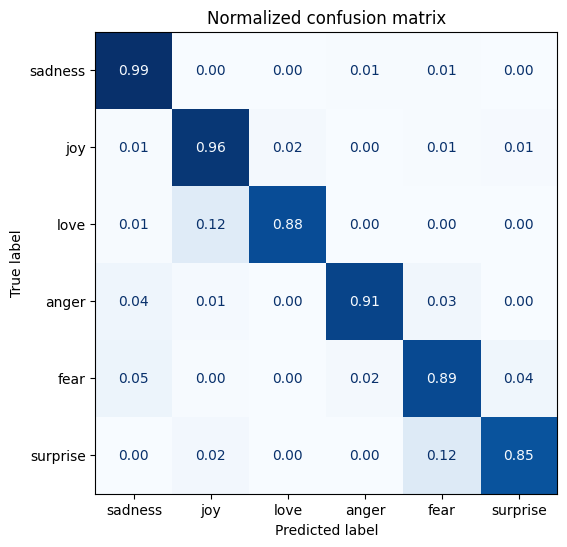

In [35]:
plot_confusion_matrix(y_preds, y_valid, labels)

### PUSHING HODEL TO HUB

In [36]:
trainer.push_to_hub(commit_message="Training completed!")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/frktsc/emotion/tree/main/'

<div style="background-color:green; color:white; padding:20px; text-align:center; width:100%; margin:auto; font-size:24px;">
      MODEL PREDICTION
</div>

In this section, we're going to look at the performance of our model.

In [37]:
from transformers import pipeline

model_id = "frktsc/emotion"
classifier = pipeline("text-classification", model= model_id)

Exception ignored in: <function _xla_gc_callback at 0x7903bcdc8790>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

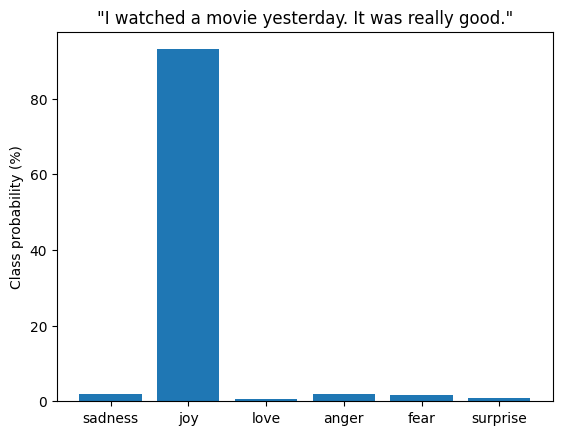

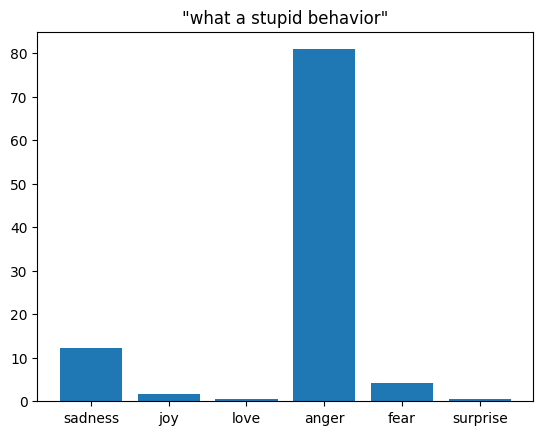

In [55]:
custom_text="I watched a movie yesterday. It was really good."
custom_text2="what a stupid behavior"
preds=classifier(custom_text, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()
preds=classifier(custom_text2, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text2}"')
plt.show()

### Thanks for reading! If you enjoyed this notebook, don't forget to upvote 👍